[EP03] EXPLORATION_IC3 : 어제 오른 내 주식, 과연 내일은?


   < 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다>
   



##목차##


(1) 시계열 데이터 준비

(2) 각종 전처리 수행

(3) 시계열 안정성 분석

(4) 학습, 테스트 데이터셋 생성

(5) 적정 ARIMA 모수 찾기

(6) ARIMA 모델 훈련과 테스트

(7) 다른 주식 종목 예측해 보기

(8) 회고

(9) 루브릭




1. 시계열의 안정성이 충분히 확인되었는가?

플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음

2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?

p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨

3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨



STEP 1 : 시계열 데이터 준비


    칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

    날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

    우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [61]:
##(1)  시계열 데이터 준비##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import os
import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/문서/GitHub/Exploration/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


데이터와 모듈을 불러오자.

Date칼럼을 index_col 인덱스 칼럼으로 바꿔준다.

데이터를 확인해준다.

칼럼들은 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)을 나타낸다.

In [62]:
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

당일 주식 장의 마감 가격인 'close'만 사용할 예정이다.

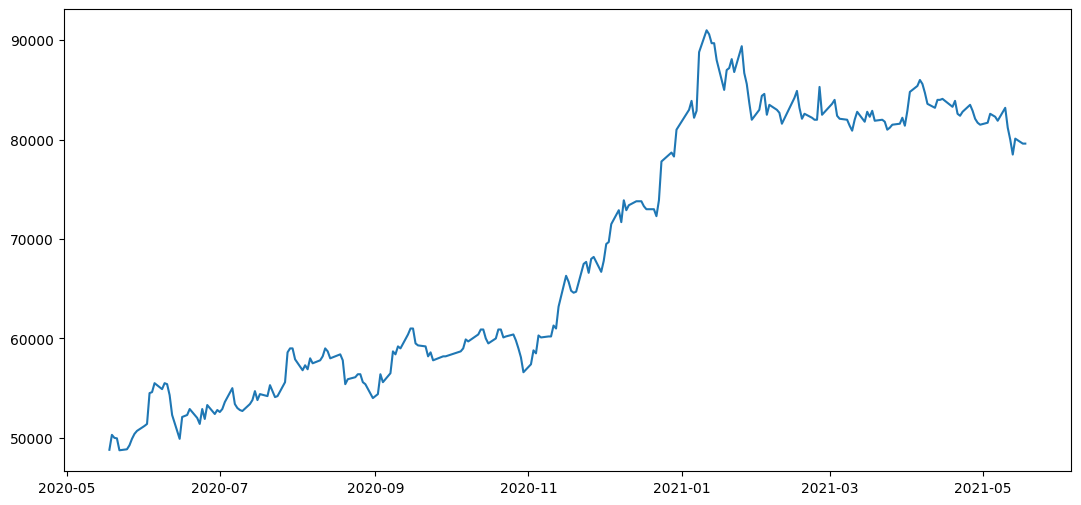

In [63]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts)

그래프로써 보기쉽게 확인해보자.

STEP 2 : 각종 전처리 수행

    결측치 처리

    로그 변환

In [64]:
##(2) 각종 전처리 수행##

ts[ts.isna()]

Series([], Name: Close, dtype: float64)

시계열에서 결측치가 있는 부분만 Series로 출력.

결측치가 없는 데이터다.

Series([], Name: Close, dtype: float64)


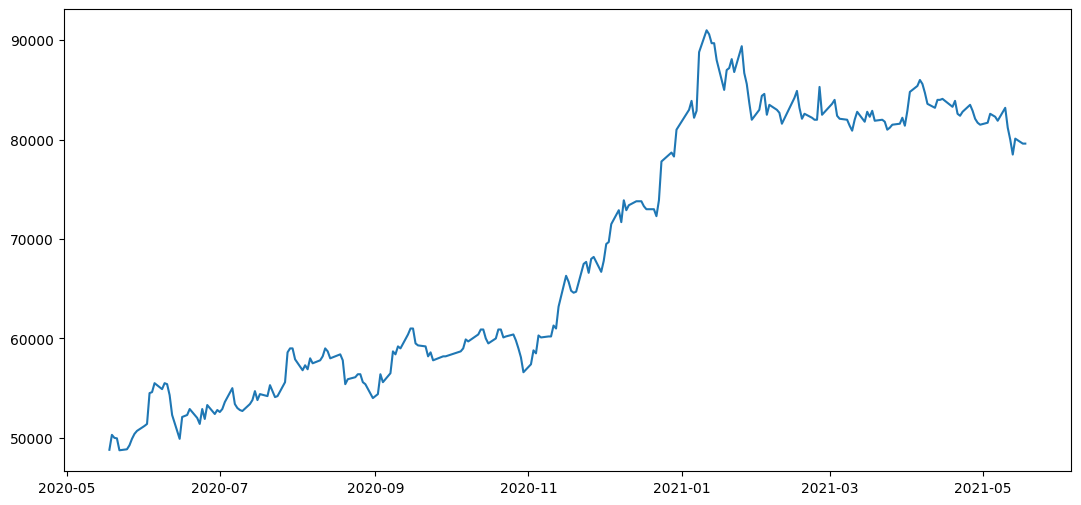

In [65]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

만약에 전 단계에서 결측치가 출력 되었다면 이번 코드로 결측치들을 보간,
interpolate()함수로  결측치를 제거해준다.

In [86]:
# 로그 변환
ts_log = np.log(ts)

STEP 3 : 시계열 안정성 분석

    정성적 그래프 분석

    정량적 Augmented Dicky-Fuller Test

    시계열 분해(Time Series Decomposition)
    
    Residual 안정성 확인

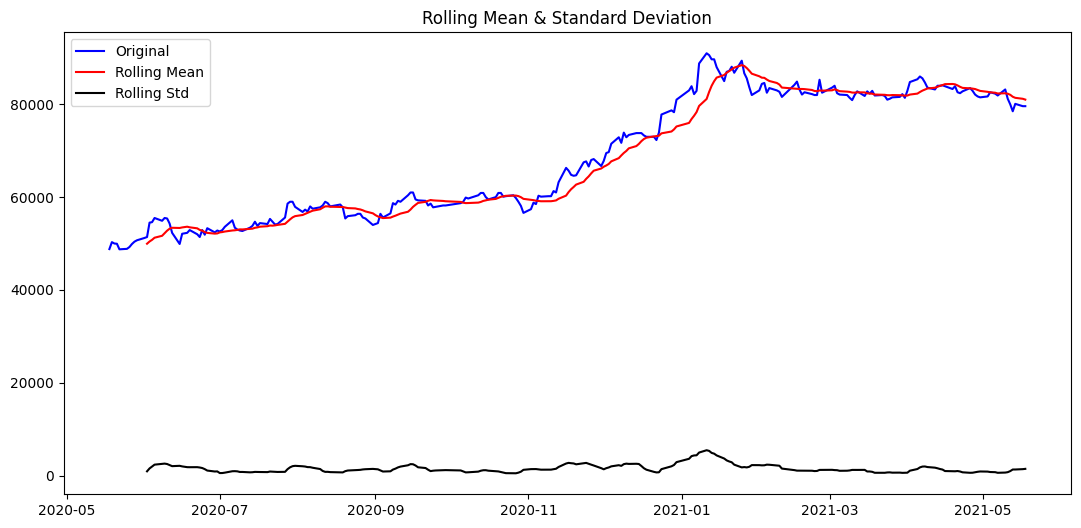

In [87]:
##(3) 시계열 안정성 분석##

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() 
    rolstd = timeseries.rolling(window=window).std()   

    
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts, window=12)

구간 통계치(Rolling Statistics)를 시각화.

원본시계열, 이동평균, 이동표준편차를 plot으로 비교해본다.

시간에 따라 평균과 분산이 비례하면 이 시계열은 안정적이진 않다고 생각할 수 있다.

In [91]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Statsmodels 패키지에서 제공하는 adfuller메소드는 
Augmented Dickey Fuller Test를 수행하는 코드다.

adfuller메소드가 도출한 결과를 정리하여 출력.

In [92]:
augmented_dickey_fuller_test(ts)


Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value의 정의는 귀무가설을 가정했을 때의 확률분포 상에서 현재의 관측보다 더 극단적인 관측이 나올 확률로써, 귀무가설의 가정이 틀렸다고 볼 수 있는 확률이기도 하다. 

이 값이 0.05 미만으로 매우 낮게 나온다면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 된다.

즉, p-value가 1에 가깝다는 것이 해당 귀무가설이 이 옳다는 증거가 될수는 없다.

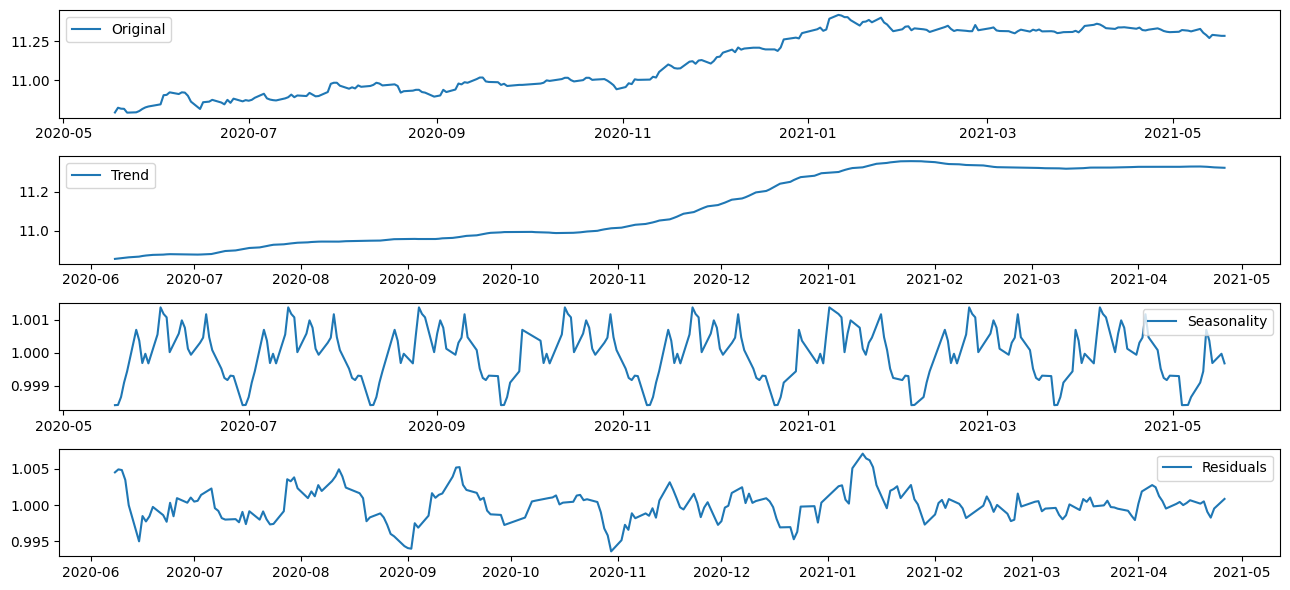

In [70]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

시계열을 분석하려면 안정적인 시계열로 바꿔줘야하는데 두가지 방법이 있다.

첫번째는 기존의 시계열 데이터를 가공하는 시도.

두번째는 시계열 분해기법 사용이다.

데이터를 더 안정적으로 바꿔주기 위해 로그변환, rolling mean제거 (추세Trend` 상쇄)

In [71]:
from statsmodels.tsa.stattools import adfuller

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


STEP 4 : 학습, 테스트 데이터셋 생성

    학습, 테스트 데이터셋 분리

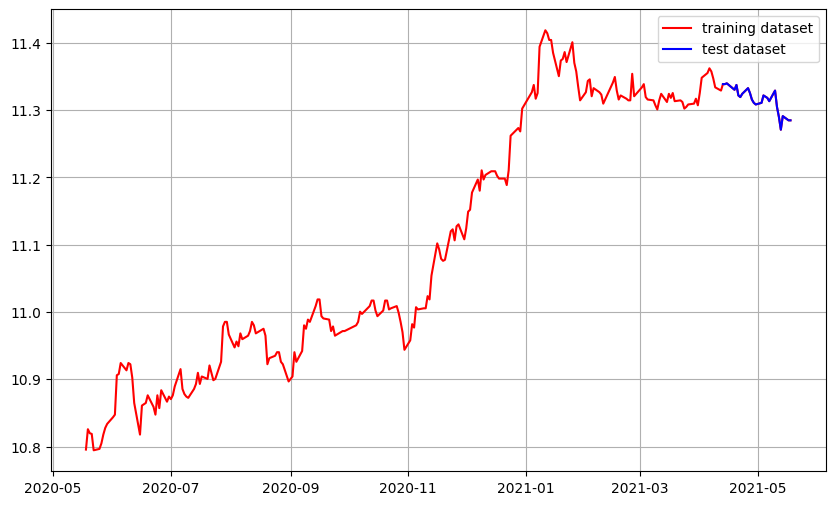

In [72]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

STEP 5 : 적정 ARIMA 모수 찾기

    ACF, PACF 그려보기 -> p,q 구하기

    차분 안정성 확인 -> d 구하기

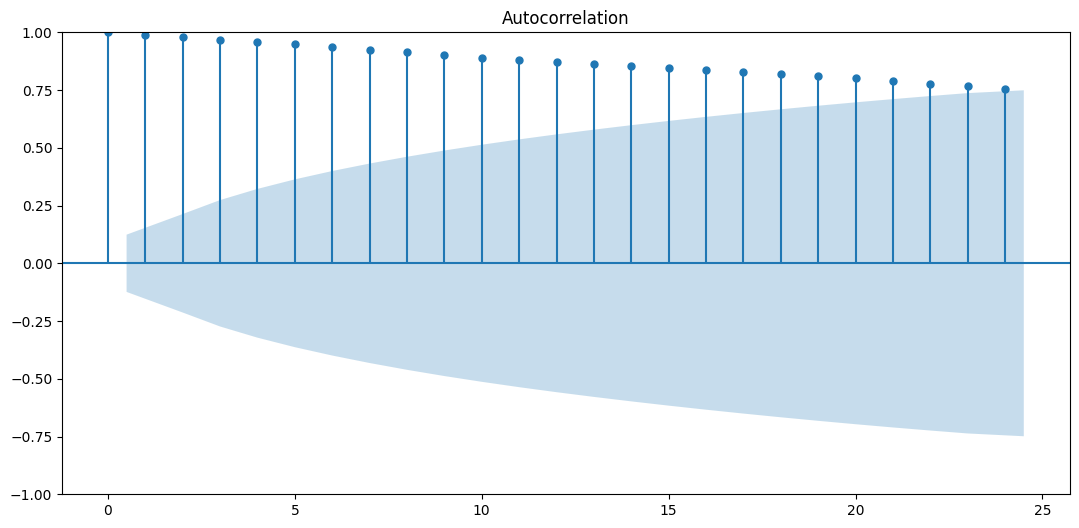

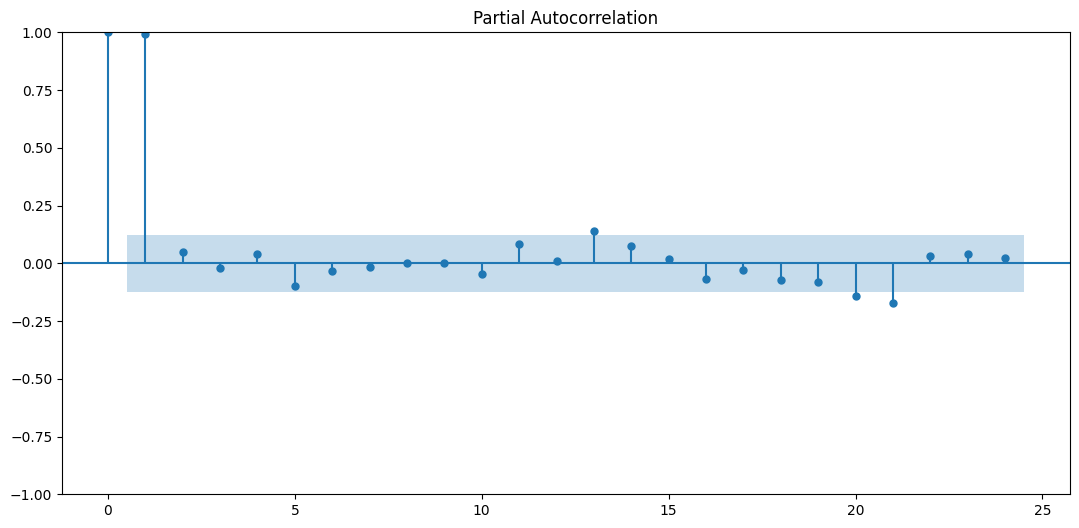

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


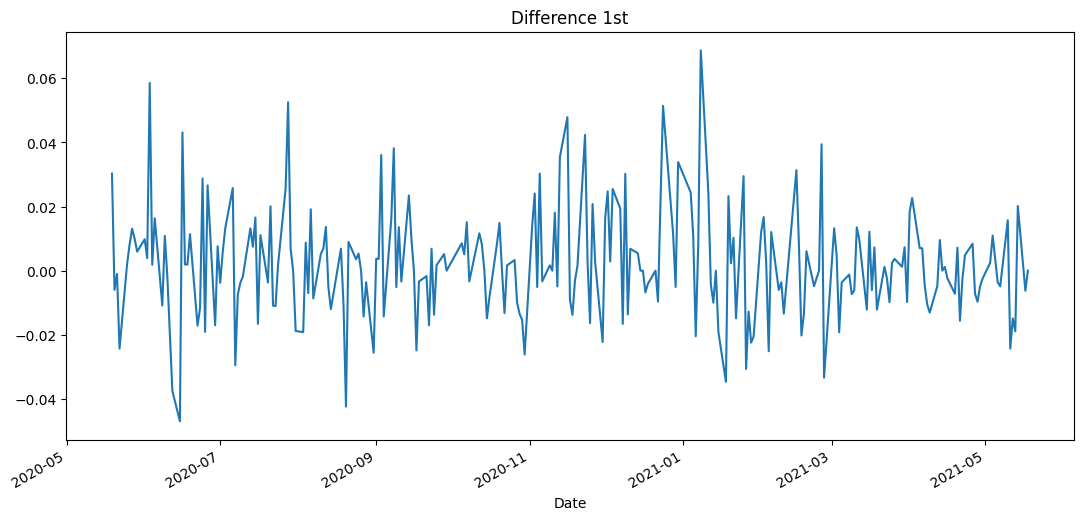

In [74]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


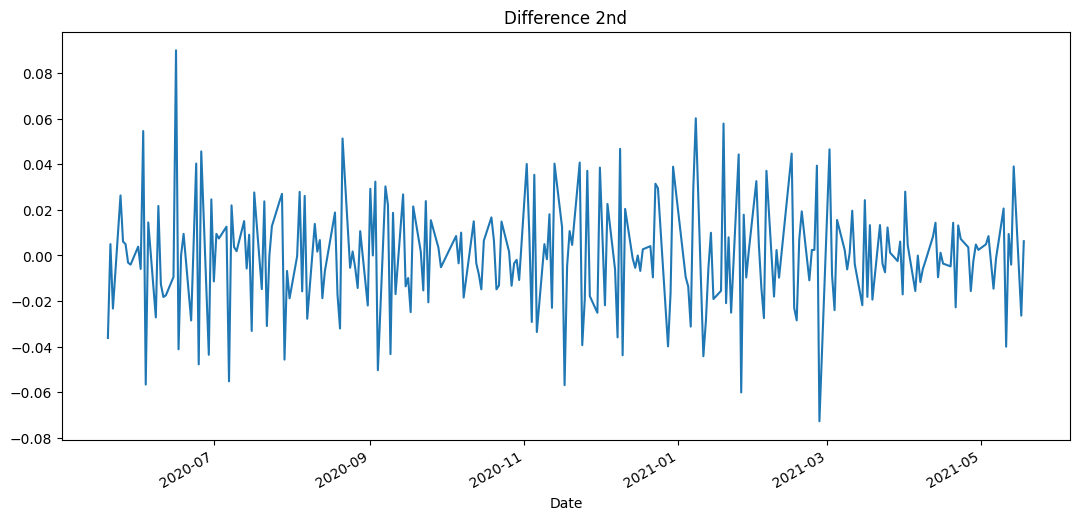

In [75]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

STEP6 : ARIMA 모델 훈련과 테스트

    ARIMA 모델 훈련과 추론

    ARIMA 모델 빌드와 훈련

    모델 테스트 및 플로팅

    최종 예측 모델 정확도 측정(MAPE)

In [85]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Fri, 30 Sep 2022   AIC                          -1156.722
Time:                        22:34:32   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

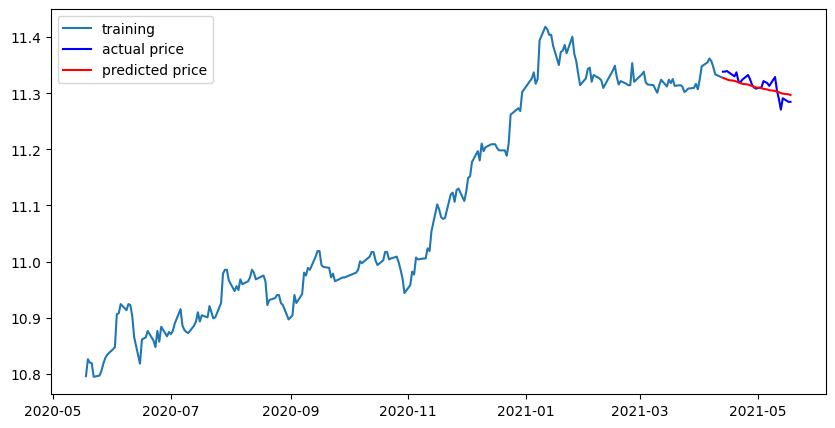

In [77]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

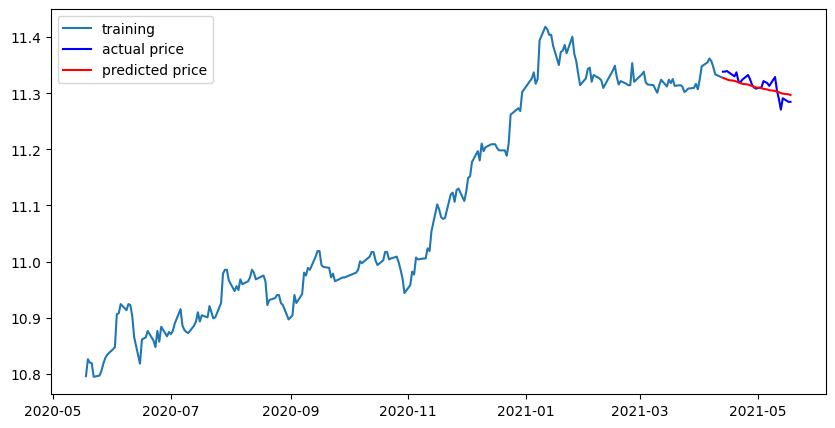

In [79]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%
